1. **Letter Reading** (MNIST)
2. **Face Recognition** (LFW)
3. **Scene identification** (Places365)

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
import os
import glob
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from scipy import signal
from sklearn.datasets import fetch_openml, fetch_lfw_people
from sklearn.model_selection import train_test_split

import cv2 as cv
from PIL import Image, ImageOps

In [188]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


SystemError: ignored

In [ ]:
mnist = fetch_openml('mnist_784', cache=False, as_frame=False)
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

KeyboardInterrupt: ignored

In [ ]:
print(mnist.DESCR)
print(lfw_people.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

# **Create X and y**

In [ ]:
X = mnist.data.astype('float32')
X /= 255
y = mnist.target.astype('int64')

print(X.shape, y.shape)
print(np.unique(y))
print(X.min(), X.max(), y.min(), y.max())

(70000, 784) (70000,)
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0 0 9


In [ ]:
X = lfw_people.data.astype('float32')
X /= 255.0
y = lfw_people.target.astype('int64')

print(X.shape, y.shape)
print(np.unique(y))
print(X.min(), X.max(), y.min(), y.max())

(1140, 1850) (1140,)
[0 1 2 3 4]
0.0 1.0 0 4


 Custom dataset

In [227]:
from glob import glob

# PATH = '/content/drive/MyDrive/Project/data/Fig4_Anodic'
PATH = '/content/drive/MyDrive/Project/data/Fig4_Cathodic'

os.chdir(PATH)

for (i, filename) in enumerate(sorted(glob('*.png'))):
  tmp_X = cv.imread(os.path.join(PATH, filename), cv.IMREAD_GRAYSCALE)

  tmp_X = np.array(tmp_X.astype(np.float32))
  tmp_X = np.expand_dims(tmp_X, axis=0)
  tmp_X /= 255.0

  if i == 0:
    X = tmp_X
    h,  w = X.shape[1], X.shape[2]
  else:
    tmp_X = tmp_X[:, :h, :w]
    X = np.concatenate([X, tmp_X], axis=0)

y = np.array([0] * X.shape[0])
print(X.shape, y.shape)
print(np.unique(y))
print(X.min(), X.max(), y.min(), y.max())

(8, 317, 317) (8,)
[0]
0.0 0.94509804 0 0


Single image

In [ ]:
PATH = '/content/drive/MyDrive/data/Fig4_ver01_220908_data099.anodic.frame1048to1748/Fig4_ver01_220908_data099.anodic.frame1048.png' # Dr. Jung 2
# X = cv.imread('/content/drive/MyDrive/data/sieoms_dataset/original/indoor1.jpg', cv.IMREAD_GRAYSCALE)
# X = cv.imread('/content/drive/MyDrive/Screen Shot 2022-08-10 at 1.37.08 PM.png', cv.IMREAD_GRAYSCALE) # Celine
# X = cv.imread('/content/drive/MyDrive/Screen Shot 2022-08-10 at 10.30.19 PM.png', cv.IMREAD_GRAYSCALE) # Celine
X = cv.imread(PATH, cv.IMREAD_GRAYSCALE)

X = np.array(X.astype(np.float32))
X = np.expand_dims(X, axis=0)
X /= 255.0
y = np.array([0])

print(X.shape, y.shape)
print(np.unique(y))
print(X.min(), X.max(), y.min(), y.max())

(1, 317, 317) (1,)
[0]
0.0 1.0 0 0


# **Choose data**

In [228]:
which_data = 'places' # mnist or lfw_people or places

In [229]:
if which_data != 'places':
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  assert(X_train.shape[0] + X_test.shape[0] == which_data.data.shape[0])
else:
  X_train, y_train = X, y

# **Edge detecting algorithm**

Plot Sobel edge-detected images

In [ ]:
def plot_example(X, y, n, w, h):
    """Plot the first n images and their labels in a row."""
    fig, axes = plt.subplots(3, n, figsize=(5*n, 5*3))
    for i, (img, label) in enumerate(zip(X[ :n].reshape(n, w, h), y[ :n])):       
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        # axes[0, i].set_title(label, fontsize=100)

        img = np.uint8(img*255)
        canny = cv.Canny(img, 100, 200)
        axes[1, i].imshow(canny, cmap='gray')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        edges_x = cv.Sobel(img, cv.CV_8U, 1, 0, ksize=3)
        edges_x = cv.convertScaleAbs(edges_x)
        edges_y = cv.Sobel(img, cv.CV_8U, 0, 1, ksize=3)
        edges_y = cv.convertScaleAbs(edges_y)
        edges_xy = cv.Sobel(img, cv.CV_8U, dx=1, dy=1, ksize=3)
        edges_xy = cv.convertScaleAbs(edges_xy)
        sobel = cv.addWeighted(edges_x, 1, edges_y, 1, 0)
        sobel = cv.addWeighted(sobel, 2/3, edges_xy, 1/3, 0)
        axes[2, i].imshow(sobel, cmap='gray')
        axes[2, i].set_xticks([])
        axes[2, i].set_yticks([])
    plt.show()

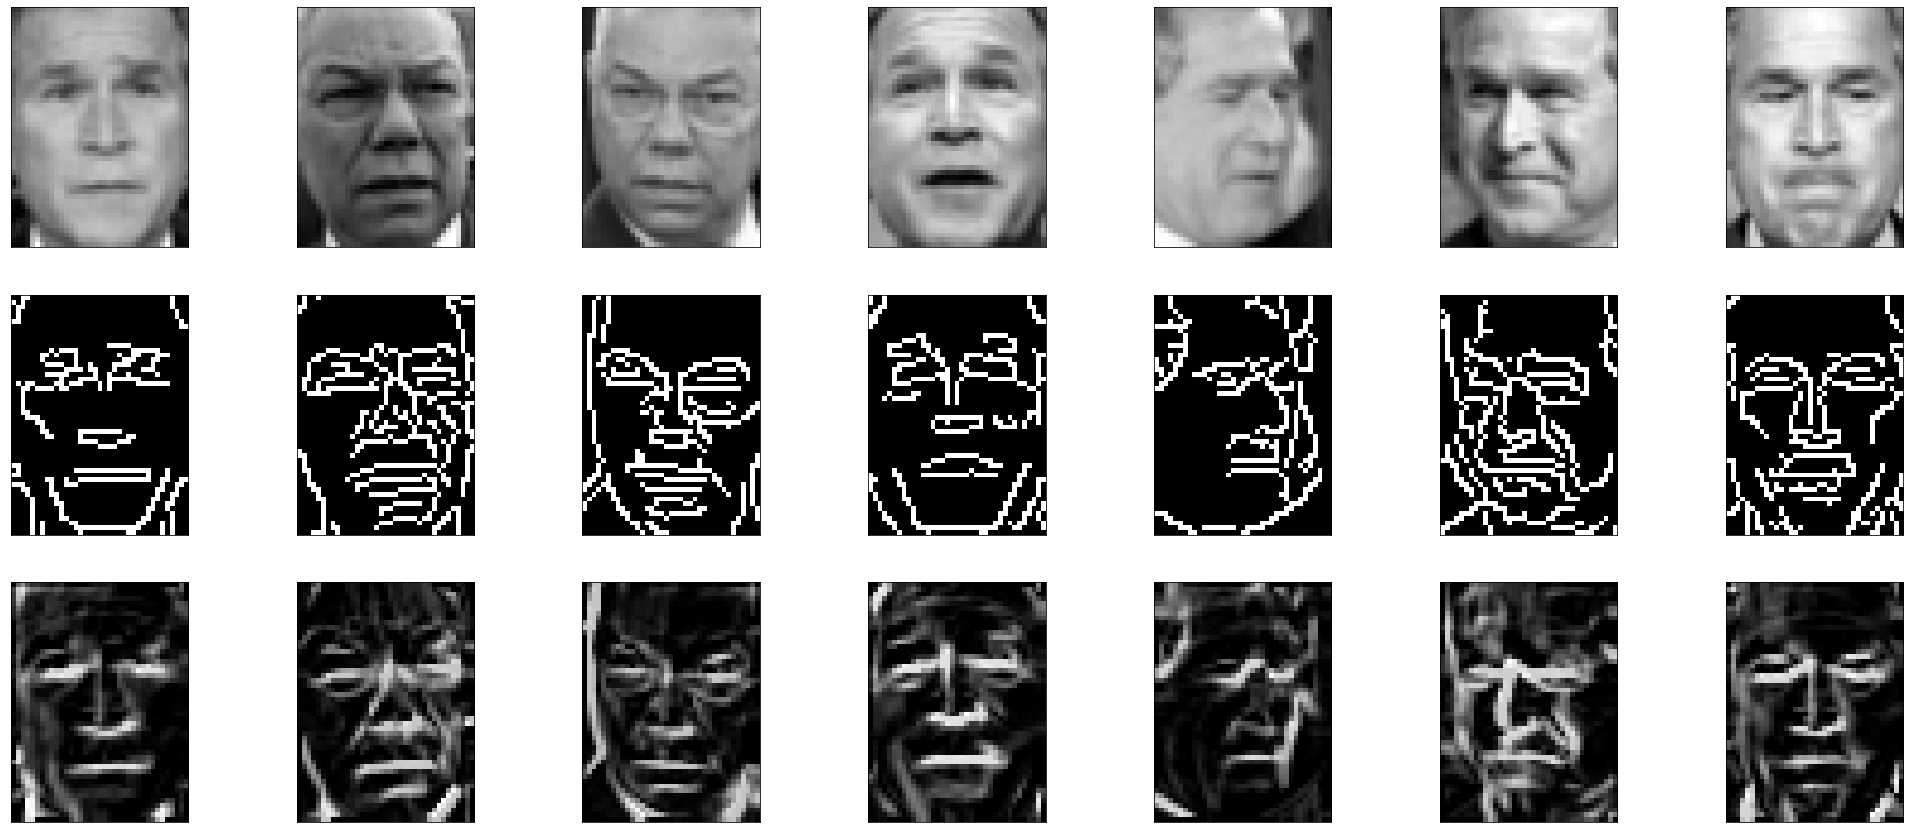

In [ ]:
num = 7
if which_data == mnist:
  plot_example(X_train, y_train, num, 28, 28)
elif which_data == lfw_people:
  plot_example(X_train, y_train, num, 50, 37)

Plot Canny edge-detected images

In [ ]:
def plot_example(data_type, X, y, k, n, w, h):

  plt.imshow(X[0])
  plt.show()

  fig, axes = plt.subplots(n, k, figsize=(h//4*k, w//4*n))
  fig.subplots_adjust(hspace=0.1, wspace=0)

  if data_type != 'places':
    reshaped_X = X[ :n].reshape(n, w, h)
  else:
    reshaped_X = np.resize(X[ :n], (w, h))
    reshaped_X = np.expand_dims(reshaped_X, axis=0)

  for i, (img, label) in enumerate(zip(reshaped_X, y[ :n])):
    for j in range(k):       
      if j != 0:  
        conv_img = np.uint8(img*255)
        conv_img = cv.Canny(conv_img, (100//k)*j, 40) # (100//k)*j, 200 # 55, 175+(100//k)*j
      else:
        conv_img = img

      if data_type != 'places':
        axes[i, j].imshow(conv_img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
      else:
        axes[j].imshow(conv_img, cmap='gray')
        axes[j].set_xticks([])
        axes[j].set_yticks([])

  plt.show()

In [ ]:
hyper_num = 5 # 5 10
sample_num = 1 # 1 5
if which_data == mnist:
  plot_example('mnist', X_train, y_train, hyper_num, sample_num, 28, 28)
elif which_data == lfw_people:
  plot_example('lwf_people', X_train, y_train, hyper_num, sample_num, 50, 37)
elif which_data == 'places':
  plot_example('places', X_train, y_train, hyper_num, sample_num, 100, 100) # 100, 100 for places / 189, 195 for Celine / 245, 291 for STARE

NameError: ignored

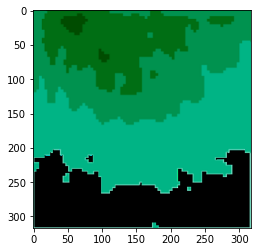

In [ ]:
plot_example('places', X_train, y_train, hyper_num, sample_num, 317, 317) # 100, 100 # 245, 291 # 42, 41

Dr. Jung

In [230]:
# rainbow = {0: (211, 90, 107),
#            1: (247, 178, 110),
#            2: (209, 234, 178),
#            3: (133, 204, 181),
#            4: (102, 173, 181),
#            5: (146, 166, 204),
#            6: (84, 114, 175),
#            7: (139, 20, 128)} # pastel

rainbow = {0: (162,20,47),
           1: (217,83,25),
           2: (237,177,32),
           3: (119,172,48),
           4: (77,190,238),
           5: (0,114,189),
           6: (126,47,142),
           7: (162,20,47)} # matlab

Unsmoothed edges

In [231]:
for i in range(X.shape[0]):
  img = X_train[i, :, :] * 255

  # get the outer borderline only
  img = np.where(img > 0, 255, img) # the most outer boarder

  # edge detect with Sobel operator
  edges_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
  edges_x = cv.convertScaleAbs(edges_x)
  edges_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
  edges_y = cv.convertScaleAbs(edges_y)
  edges_xy = cv.Sobel(img, cv.CV_64F, dx=1, dy=1, ksize=3)
  edges_xy = cv.convertScaleAbs(edges_xy)

  sobel = cv.addWeighted(edges_x, 1, edges_y, 1, 0)
  sobel = cv.addWeighted(sobel, 1, edges_xy, 1, 0)

  # make it into binary image
  sobel = np.where(sobel < 128, 0, sobel)
  sobel = np.where(sobel >= 128, 255, sobel)

  # erase the borderlines (DEPRECATED)
  # sobel[:3, :] = 0 # top
  # sobel[sobel.shape[0]-3:sobel.shape[0], :] = 0 # bottom
  # sobel[:, :3] = 0 # left
  # sobel[:, sobel.shape[0]-3:] = 0 # right

  # resize the image (DEPRECATED)
  # sobel = cv.resize(sobel, dsize=(224, 224), interpolation=cv.INTER_CUBIC)

  # smooth the edge
  sobel = cv.GaussianBlur(sobel, ksize=(1, 1), sigmaX=1, sigmaY=1, borderType = cv.BORDER_DEFAULT)

  sobel = np.where(sobel > 0, 255, sobel)

  # to make green contour lines
  sobel = np.expand_dims(sobel, axis=-1)
  sobel = np.concatenate([sobel, sobel, sobel], axis=-1)

  # change black and white (DEPRECATED)
  # sobel = np.where(sobel == 255, -255, sobel) # 255 -> -255, 0 -> 0
  # sobel += 255 # 255 -> 0, 0 -> 255
  
  sobel = np.where(sobel==(255, 255, 255), rainbow[i], sobel)
  sobel = sobel / 255. # change it to float

  alphas = np.ones((sobel.shape[0], sobel.shape[1]))
  alphas = np.where(sobel[:, :, 0] == 0, 0, alphas)
  alphas = np.expand_dims(alphas, axis=-1)

  sobel = np.concatenate([sobel, alphas], axis=-1)
  # print(np.unique(sobel))

  # visualize 
  # plt.imshow(sobel) #, cmap= 'gray') # same dtype for all dimensions
  # # plt.rcParams['figure.facecolor']='white'
  # plt.axis('off')
  # plt.xticks([])
  # plt.yticks([])
  # plt.show()

  # save the image
  plt.imsave(f'/content/drive/MyDrive/Project/data/Fig4_Anodic_Output/{i}.png', sobel)

Smoothed edges

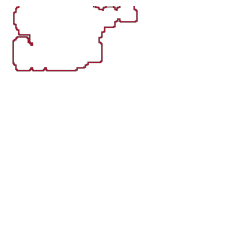

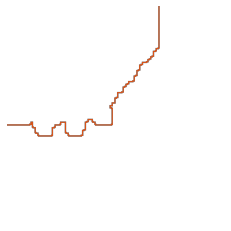

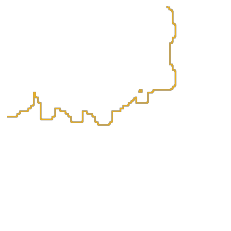

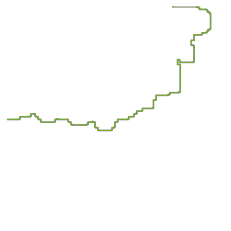

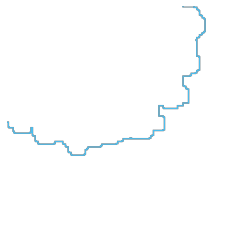

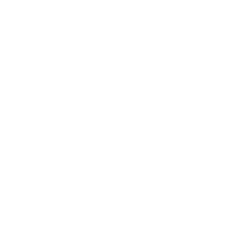

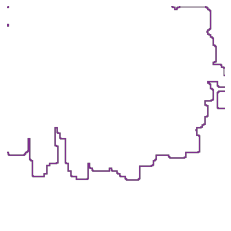

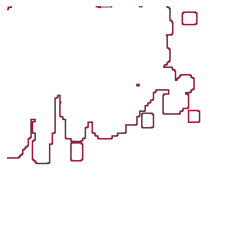

In [235]:
for i in range(X.shape[0]):
  img = X_train[i, :, :] * 255

  # blur the image so we could get smoothed edges
  img = cv.GaussianBlur(img, ksize=(11, 11), sigmaX=7, sigmaY=7)

  # get the outer borderline only
  img = np.where(img > 0, 255, img) # the most outer boarder

  # edge detect with Sobel operator
  edges_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
  edges_x = cv.convertScaleAbs(edges_x)
  edges_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
  edges_y = cv.convertScaleAbs(edges_y)
  edges_xy = cv.Sobel(img, cv.CV_64F, dx=1, dy=1, ksize=3)
  edges_xy = cv.convertScaleAbs(edges_xy)

  sobel = cv.addWeighted(edges_x, 1, edges_y, 1, 0)
  sobel = cv.addWeighted(sobel, 1, edges_xy, 1, 0)

  # make it into binary image
  sobel = np.where(sobel < 128, 0, sobel)
  sobel = np.where(sobel >= 128, 255, sobel)

  # erase the borderlines (DEPRECATED)
  # sobel[:3, :] = 0 # top
  # sobel[sobel.shape[0]-3:sobel.shape[0], :] = 0 # bottom
  # sobel[:, :3] = 0 # left
  # sobel[:, sobel.shape[0]-3:] = 0 # right

  # resize the image (DEPRECATED)
  # sobel = cv.resize(sobel, dsize=(224, 224), interpolation=cv.INTER_CUBIC)

  # smooth the edge
  sobel = cv.GaussianBlur(sobel, ksize=(1, 1), sigmaX=1, sigmaY=1, borderType = cv.BORDER_DEFAULT)

  sobel = np.where(sobel > 0, 255, sobel)

  # to make green contour lines
  sobel = np.expand_dims(sobel, axis=-1)
  sobel = np.concatenate([sobel, sobel, sobel], axis=-1)

  # change black and white (DEPRECATED)
  # sobel = np.where(sobel == 255, -255, sobel) # 255 -> -255, 0 -> 0
  # sobel += 255 # 255 -> 0, 0 -> 255
  
  sobel = np.where(sobel==(255, 255, 255), rainbow[i], sobel)
  sobel = sobel / 255. # change it to float

  alphas = np.ones((sobel.shape[0], sobel.shape[1]))
  alphas = np.where(sobel[:, :, 0] == 0, 0, alphas)
  alphas = np.expand_dims(alphas, axis=-1)

  sobel = np.concatenate([sobel, alphas], axis=-1)
  # print(np.unique(sobel))

  # visualize 
  plt.imshow(sobel) #, cmap= 'gray') # same dtype for all dimensions
  # plt.rcParams['figure.facecolor']='white'
  plt.axis('off')
  plt.xticks([])
  plt.yticks([])
  plt.show()

  # save the image
  plt.imsave(f'/content/drive/MyDrive/Project/data/Fig4_Cathodic_Output/{i}.png', sobel)